In [1]:
import sys
# sys.path.insert(0, '/usr/local/lib/python2.7/site-packages/')
import numpy as np
import pandas as pd

# Load SiouxFall dataset

In [2]:
def parse_net(input_file='./data/SiouxFalls_net.txt'):
    '''
    Read graphs description
    '''
    
    # read raw txt
    fin = open(input_file)
    data = []
    for line in fin:
        data.append(line)
    fin.close()
    
    # prepare fields
    fields = ['init_node',
        'term_node', 
        'capacity', 
        'length', 
        'free_flow', 
        'time', 
        'b', 
        'power', 
        'speed_limit', 
        'toll_type']

    mapper = {}
    for f in fields:
        mapper[f] = int

    for f in ['capacity', 'time']:
        mapper[f] = float
    
    # process lines
    dataset = []
    for line in data[8:]:
        cur_dict = {}
        tokens = line.split()[:-1]
        assert len(tokens)==len(fields)
        for key, value in zip(fields, tokens):
            cur_dict[key] = mapper[key](value)
        dataset.append(cur_dict)
    
    return pd.DataFrame(dataset)


def parse_trips(input_file = './data/SiouxFalls_trips.txt'):
    '''
    Read correspondence matrix
    '''
    fin = open(input_file)
    data = []
    for line in fin:
        data.append(line)
    fin.close()

    flows = np.zeros((24, 24))

    for r,i in enumerate(range(6,len(data),7)[:-1]):
        flows[r, 0:5]   = np.array(map(lambda x: float(x[:-1]), data[i+0].split()[2::3]))
        flows[r, 5:10]  = np.array(map(lambda x: float(x[:-1]), data[i+1].split()[2::3]))
        flows[r, 10:15] = np.array(map(lambda x: float(x[:-1]), data[i+2].split()[2::3]))
        flows[r, 15:20] = np.array(map(lambda x: float(x[:-1]), data[i+3].split()[2::3]))
        flows[r, 20:24] = np.array(map(lambda x: float(x[:-1]), data[i+4].split()[2::3]))

    assert np.sum(flows) == 360600.0
    return flows


In [3]:
# read matrix d and description of graph
d = parse_trips('./data/SiouxFalls_trips.txt')
net_df = parse_net('./data/SiouxFalls_net.txt')

# first 5 records (just example)
net_df.head()

b      capacity  free_flow  init_node  length  power  speed_limit  \
0  4  25900.200640          6          1       6      0            0   
1  4  23403.473190          4          1       4      0            0   
2  4  25900.200640          6          2       6      0            0   
3  4   4958.180928          5          2       5      0            0   
4  4  23403.473190          4          3       4      0            0   

   term_node  time  toll_type  
0          2  0.15          1  
1          3  0.15          1  
2          1  0.15          1  
3          6  0.15          1  
4          1  0.15          1

In [4]:
n_edges = 76
n_vertex  = 24
n_sources = 24
n_destinations = 24
'''
All code expects that n_sources == n_vertex == n_destinations
'''

f_ = np.zeros((n_vertex, n_vertex))
t_ = np.zeros((n_vertex, n_vertex))
edges = np.zeros((n_edges, 2)).astype(int)

for k, row in net_df.iterrows():
    i = int(row['init_node']) - 1 # 1-based numeration in source -> convert to 0-based
    j = int(row['term_node']) - 1
    f_[i, j] = row['capacity']
    t_[i, j] = row['free_flow']
    edges[k] = [i, j]

f_ = f_ * 5

print "sum of f_ * t_ : {}".format(np.sum([f_[i,j]*t_[i, j] for i,j in edges.astype(int)]))

nu = 1.0 / (4* n_vertex * f_ *np.log(n_sources + 1))
eps = 1e+6
nu = nu * eps

sum of f_ * t_ : 15273560.6923


# Generate init point

In [5]:
import networkx as nx

# create graph
dg = nx.DiGraph() # Di For Directed 
dg.add_weighted_edges_from([(i, j, t_[i,j]) for i, j in edges.astype(int)])

# generate initial T_ij as shortest weighted path
init_T = np.zeros((n_vertex, n_vertex))
for i in range(n_vertex):
    for j in range(n_vertex):
        init_T[i,j] = nx.algorithms.dijkstra_path_length(dg, i, j)

### Draw graph

Populating the interactive namespace from numpy and matplotlib


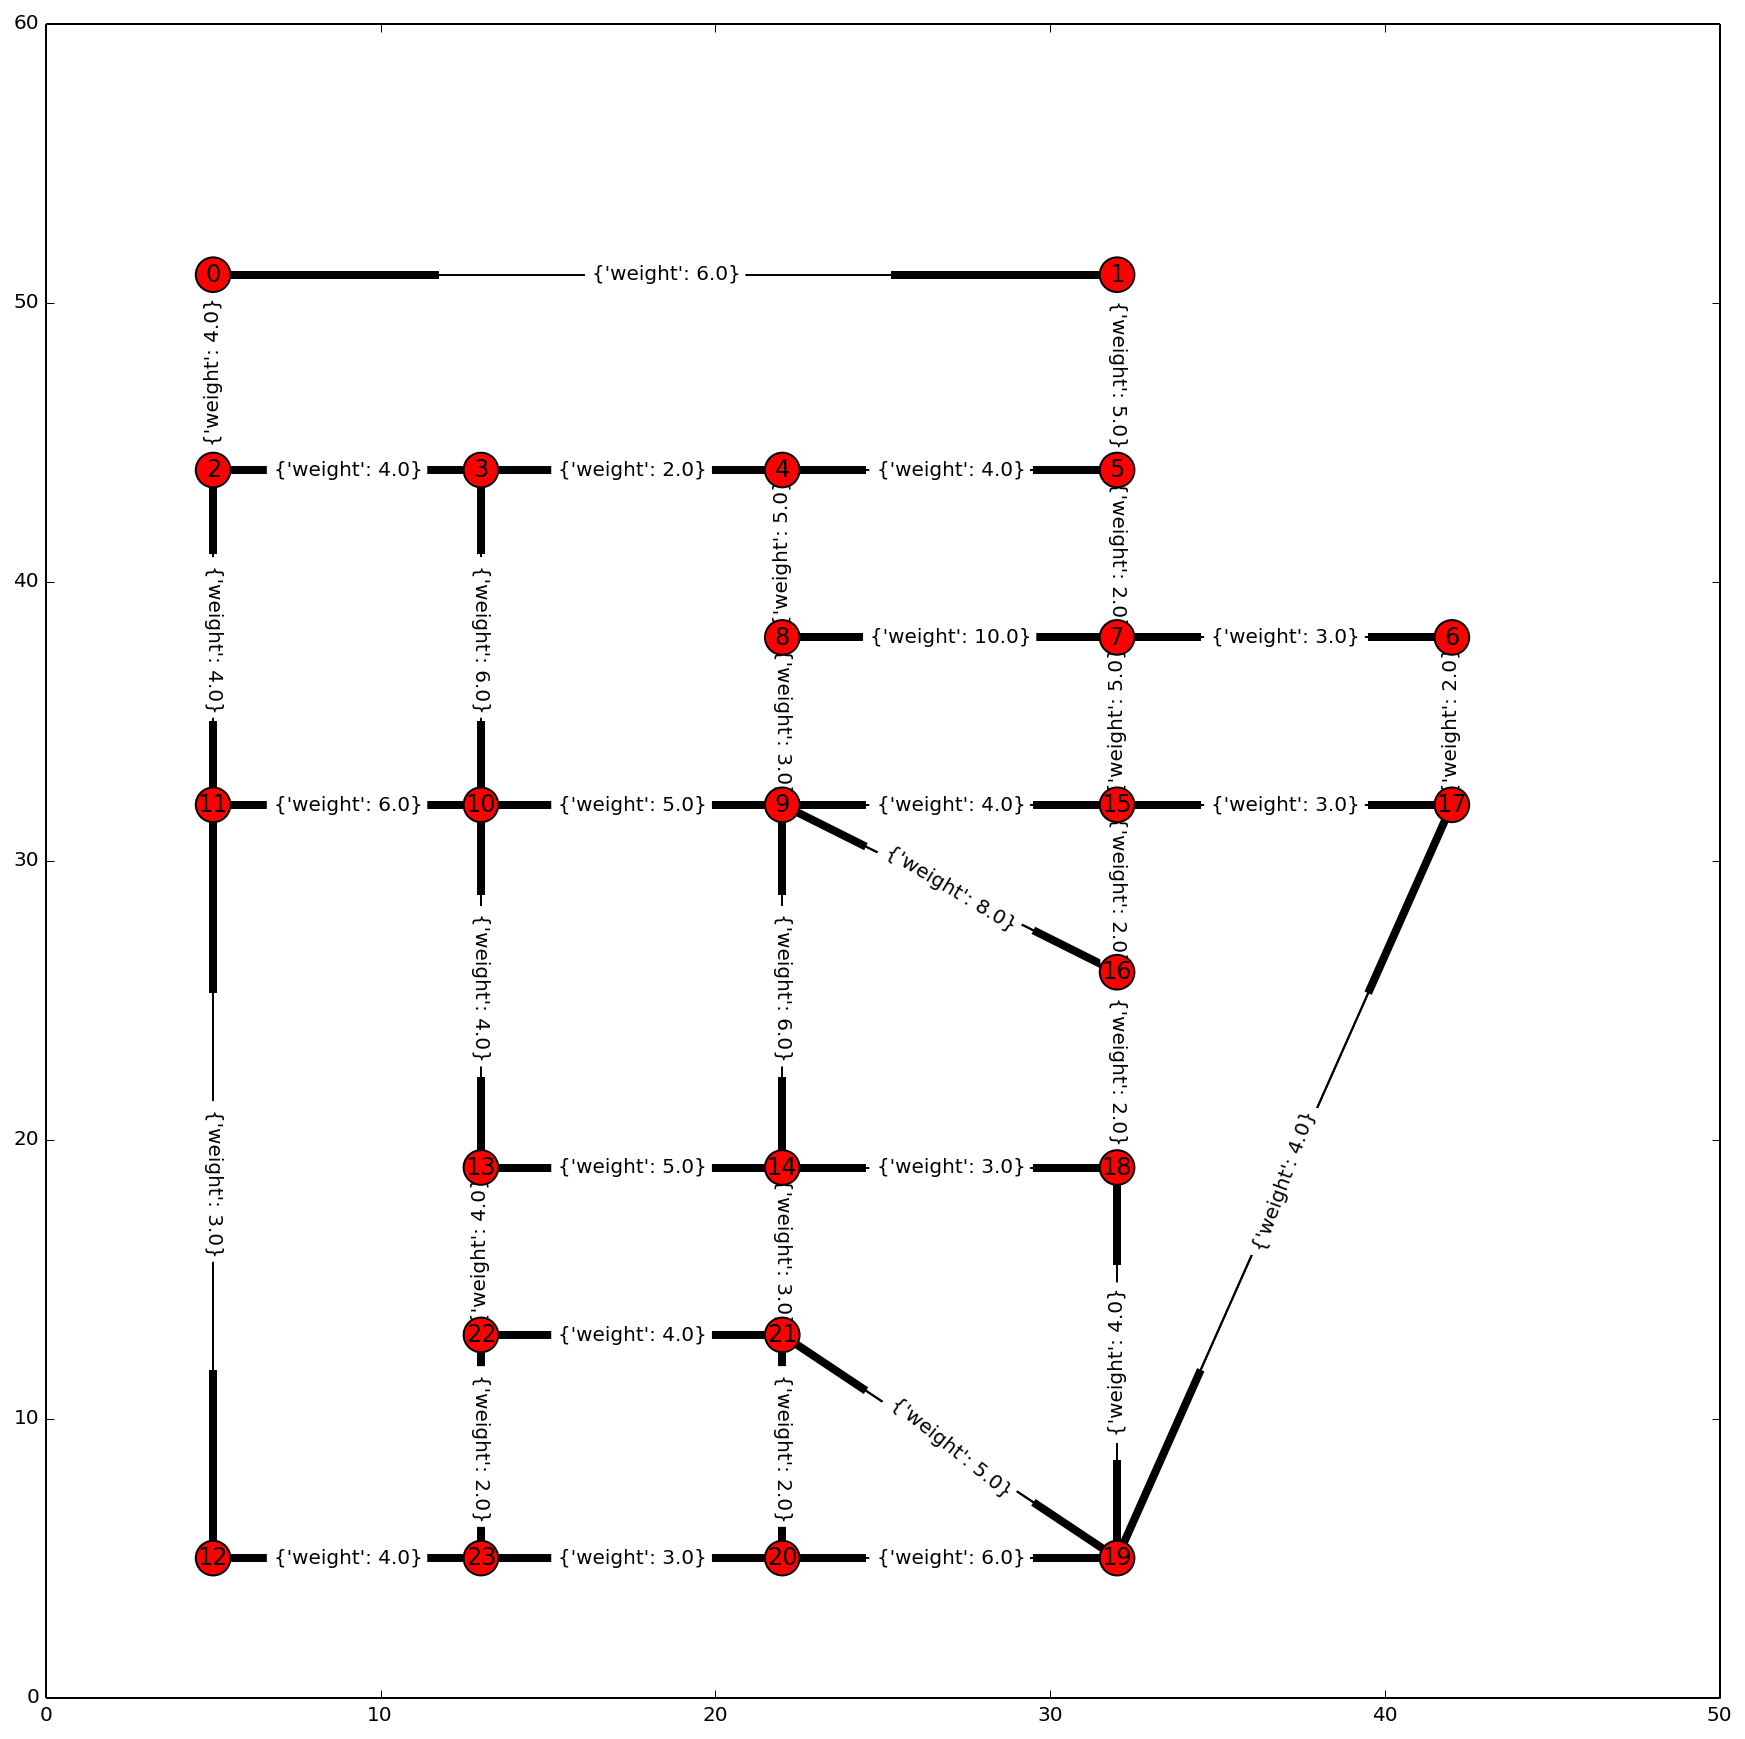

In [7]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

# load coorditanes
pos = {}
for i, row in pd.read_csv('./data/SiouxFalls_node.txt', sep='\t').iterrows():
    pos[i] = np.array((row['X'] *1.0/ 10000, row['Y'] *1.0/ 10000))
    
# draw graph
figsize(15, 15)
node_labels = nx.draw_networkx_labels(dg, pos)
edge_labess = nx.draw_networkx_edge_labels(dg, pos)
nx.draw_networkx_nodes(dg, pos)
nx.draw_networkx_edges(dg, pos)

# Defenitions of subroutines

#### general routines

In [8]:
def robust_softmax(x):
    mx = np.max(x)
    x_ = x - mx
    exponents = np.exp(x_)
    return exponents / (np.sum(exponents) + 1.0/np.exp(min(mx, 100)))


def robust_logaritm_of_exp_sum(x):
    mx = np.max(x)
    x_ = x - mx
    exponents = np.exp(x_)
    return mx + np.log(np.sum(exponents) + 1.0/np.exp(min(mx, 100)))


def calc_functional(T, edges, d, f_, t_, nu):
    '''
    Calculates target funtional 
    '''
    res = 0
    for s in range(n_sources):
        for k in range(n_destinations):
            res += -d[s, k] * (T[s, k] - T[s, s]) 
    for i, j in edges:
        exp_arg = (T[:, j] - T[:, i] - t_[i, j]) * 1.0 / nu[i,j]
        add_ij = f_[i, j] * nu[i, j] * (np.log( 1.0 / (n_sources + 1)) + robust_logaritm_of_exp_sum(exp_arg))
        res += add_ij
    return res


def calc_F(T, edges, f_, t_, nu):
    '''
    Calculates only second sum of target function (called F in APPROX paper)
    '''
    res = 0
    for i, j in edges:
        exp_arg = (T[:, j] - T[:, i] - t_[i, j])*1.0 / nu[i,j]
        res += f_[i, j] * nu[i, j] * (np.log( 1.0 / (n_sources + 1)) + robust_logaritm_of_exp_sum(exp_arg))
    return res

#### APPROX's routines

In [9]:
def calc_Vs(f_, nu, edges, tau):
    '''
    Calculates v_i
    w_j - number of blocks which f_j depends on (f = \sum_j f_j)
    In our case, w_j = 2 for every j
    
    L_{ij, k} -- Lipschitz's constant, 
         = f_[i,j]  / nu[i, j], if k==i or k==j
         = 0, otherwise
    
    v_k = \sum beta_ij * L_ij,k
    '''
    
    n_blocks = f_.shape[0]
    w = 2
    beta = 1 + (w - 1) * (tau - 1) / max(1, n_blocks - 1) 
    
    v = np.zeros(n_blocks)
    for k in range(n_blocks):
        for i, j in edges:
            if i==k or j==k:
                L_ijk = f_[i,j]  / nu[i, j]
                v[k] += beta * L_ijk
    return v


def brutal_gradient(k, T, edges, f_, t_, nu):
    '''
    Calculates gradient approximation
    Just for checking
    '''
    value_before = calc_F(T, edges, f_, t_, nu)
    step_size = 0.001
    res = np.zeros(block_size)
    for i in range(block_size):
        # forming offset of 1 coordinates
        offset = np.zeros((n_vertex, n_vertex))
        offset[i, k] = step_size
        
        value_after = calc_F(T + offset, edges, f_, t_, nu)
        res[i]  = (value_after - value_before) / step_size
    # zeroing k-th component -- because T_kk=0 and should be constant
    res[k] = 0
    return res


def blockgrad_f(k, T, edges, f_, t_, nu, S=n_sources):
    '''
    k -- number of block
    T  -- matrix T_ij,
    f_ -- matrix with flow capacity
    nu -- matrix of precalced nu_ij
    edges -- matrix (2, n_edge)
    S -- number of sources
    
    returns vector with N elements
    '''
    assert  T.shape[0]==T.shape[1]
    res = np.zeros(T.shape[0])
    
    for i,j in edges:
        # skip non-interesting components
        if i!=k and j!=k:
            continue
        if i==k: coeff = -1
        if j==k: coeff =  1
        
        exp_arg = (T[:, j] - T[:, i] - t_[i, j])*1.0 / nu[i,j]
        res += coeff * f_[i, j] * 1.0 * robust_softmax(exp_arg)
    # zeroing k-th component
    res[k] = 0
    return res


def argmin_t(k, theta, u, z, n_blocks, v, tau, f_, t_, nu, d):
    '''
    See paper (algorithm 2, step 6) for details
    '''
    #w = brutal_gradient(k, theta**2 * u + z, edges, f_, t_, nu)
    w = blockgrad_f(k, theta**2 * u + z, edges, f_, t_, nu, 24)
    b = n_blocks * theta * v[k] * 1.0 / (2*tau)
    
    t_k = (d[:, k] - w) * 1.0 / (2*b)
    return t_k

## Initialization

In [10]:
tau = 5 # number of concurenty processed blocks
n_blocks = 24
v = calc_Vs(f_, nu, edges, tau)

z = init_T * 1.0
theta = tau * 1.0 / n_blocks
u = np.zeros((n_vertex, n_vertex))

print 'Initial func value: {}'.format(calc_functional(init_T, edges, d, f_, t_, nu))

quality = []
total_iter = 4000

Initial func value: -3471918.88953


## Main loop

In [11]:
for n_iter in range(total_iter):
    
    # sampling block uniformally
    blocks_set = np.random.choice(range(n_blocks), tau, replace=False)
    for k in blocks_set:
        t_k = argmin_t(k, theta, u, z, n_blocks, v, tau, f_, t_, nu, d)
        z[:, k] += t_k
        u[:, k] -= ((1 - n_blocks * theta * 1.0 / tau) / theta**2) * t_k
    theta = (np.sqrt(theta**4 + 4*theta**2) - theta**2) / 2
    
    q = calc_functional(theta**2 * u + z, edges, d, f_, t_, nu)
    quality.append(q) 
    
    # check for numerical problems
    if np.isnan(q) or np.isinf(q):
        print n_iter, 'ALARM -- NAN'
        break
        
    # print every 10-th result   
    if n_iter%10==0:
        print n_iter,  q

# output
T = theta**2 * u + z          

0 -3472875.77163
10 -3480954.72126
20 -3491877.2339
30 -3502678.1522
40 -3513581.9654
50 -3524904.81525
60 -3534965.4388
70 -3544869.31371
80 -3553830.20052
90 -3562359.63615
100 -3570051.85237
110 -3576972.29914
120 -3583454.82837
130 -3589469.24569
140 -3595322.39881
150 -3600898.32098
160 -3606073.4018
170 -3610808.65621
180 -3615240.83698
190 -3619336.14221
200 -3623178.80264
210 -3626829.09174
220 -3630317.56472
230 -3633614.86698
240 -3636745.79141
250 -3639676.00938
260 -3642450.54818
270 -3645054.25464
280 -3647544.76485
290 -3649920.59762
300 -3652155.38966
310 -3654297.53041
320 -3656356.9686
330 -3658335.80628
340 -3660218.98288
350 -3661991.71029
360 -3663684.52255
370 -3665300.96374
380 -3666845.05643
390 -3668320.35608
400 -3669722.63884
410 -3671072.93995
420 -3672365.31694
430 -3673586.53881
440 -3674758.50311
450 -3675883.41124
460 -3676958.07877
470 -3677988.6666
480 -3678983.68148
490 -3679939.21024
500 -3680856.65934
510 -3681745.55466
520 -3682603.36343
530 -368344

In [12]:
figsize(8, 5)
#plot(np.log(-np.array(quality)))
plot(np.array(quality))
title('Target functional')
xlabel('iterations')
ylabel('value')

In [14]:
# check for overloaded edges
for i, j in edges:
    overloaded_s  = np.sum(T[:, j] - T[:, i] - t_[i,j]>0)
    if overloaded_s > 0:
        print 'edge ({}, {}) overloaded for {} sources'.format(i, j, overloaded_s)

edge (9, 15) overloaded for 5 sources
edge (15, 9) overloaded for 9 sources
edge (15, 16) overloaded for 10 sources
edge (16, 15) overloaded for 8 sources
edge (16, 18) overloaded for 2 sources
edge (18, 16) overloaded for 2 sources
